In [16]:
%reload_ext autoreload
%autoreload 2

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

In [18]:
from helpers import *

In [19]:
df = HSIDataSetDataFrame(pd.read_csv(DATA_DIR / "index.csv"))

In [20]:
df.index

RangeIndex(start=0, stop=180, step=1)

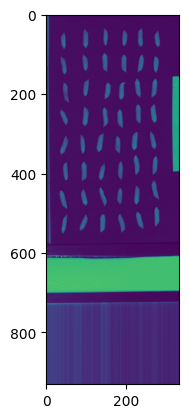

In [21]:
img_num = 13
plt.imshow(df.images[img_num].hsi_calibrated[:, :, 110])

In [22]:
from skimage import filters, morphology, measure, color

for i in range(49, 50):
    img_num = i
    threshold = 0.08
    min_area = 300
    image = df.images[img_num].hsi_calibrated[:, :, 110]
    gray_image = df.images[img_num].hsi_calibrated[:, :, 110]

    binary_mask = image[:580] > threshold
    dialated = morphology.dilation(binary_mask, morphology.disk(3))
    eroded = morphology.erosion(dialated, morphology.disk(3))

    # Perform morphological closing to join nearby regions
    closed = morphology.closing(
        eroded, morphology.disk(3)
    )  # Adjust disk size as needed

    # Remove small objects (regions with area < 100 pixels)
    filtered = morphology.remove_small_objects(closed, min_size=min_area)

    # use regioprops to get the area of each region
    regions = measure.regionprops(measure.label(filtered))
    areas = [region.area for region in regions]
    aspect_ratios = [
        region.major_axis_length / region.minor_axis_length for region in regions
    ]

    # Label connected components
    labeled_regions = measure.label(filtered)

    mask = np.zeros_like(labeled_regions, dtype=bool)
    # Loop through each region and create a mask for regions with aspect ratio <= 5
    for region in regions:
        aspect_ratio = region.major_axis_length / region.minor_axis_length
        if aspect_ratio > 5:  # Remove regions with aspect ratio > 5
            labeled_regions[labeled_regions == region.label] = 0

    # Assign random colours to each region
    colored_regions = color.label2rgb(labeled_regions, kind="overlay")

    # Display results
    # fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    # ax[0].imshow(image, cmap="gray")
    # ax[0].set_title(f"Fixed Threshold ({threshold})")
    # ax[0].axis("off")

    # ax[1].imshow(filtered, cmap="gray")
    # ax[1].set_title("After Removing Small Regions (<100 px)")
    # ax[1].axis("off")

    # ax[2].imshow(colored_regions)
    # ax[2].set_title("Segmented Regions with Unique Colours")
    # ax[2].axis("off")
    # np.unique(labeled_regions).shape[0]
    if np.unique(labeled_regions).shape[0] != 49:
        print(i, np.unique(labeled_regions).shape[0])
    # plt.show()

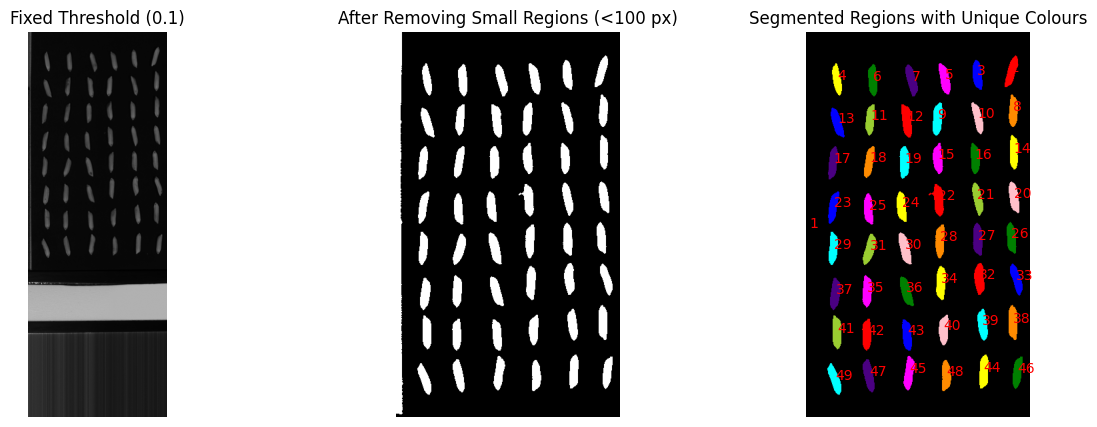

In [23]:
def segment_image(image_num, threshold=0.08, min_area=300, plot=False):
    image = df.images[img_num].hsi_calibrated[:, :, 110]
    gray_image = df.images[img_num].hsi_calibrated[:, :, 110]

    binary_mask = image[:580] > threshold
    dialated = morphology.dilation(binary_mask, morphology.disk(3))
    eroded = morphology.erosion(dialated, morphology.disk(3))

    # Perform morphological closing to join nearby regions
    closed = morphology.closing(
        eroded, morphology.disk(3)
    )  # Adjust disk size as needed

    # Remove small objects (regions with area < 100 pixels)
    filtered = morphology.remove_small_objects(closed, min_size=min_area)

    # use regioprops to get the area of each region
    regions = measure.regionprops(measure.label(filtered))
    areas = [region.area for region in regions]
    aspect_ratios = [
        region.major_axis_length / region.minor_axis_length for region in regions
    ]

    # Label connected components
    labeled_regions = measure.label(filtered)

    mask = np.zeros_like(labeled_regions, dtype=bool)
    # Loop through each region and create a mask for regions with aspect ratio <= 5
    for region in regions:
        aspect_ratio = region.major_axis_length / region.minor_axis_length
        if aspect_ratio > 5:  # Remove regions with aspect ratio > 5
            labeled_regions[labeled_regions == region.label] = 0

    # Assign random colours to each region
    colored_regions = color.label2rgb(labeled_regions, bg_label=0, kind="overlay")

    # Display results
    if plot:
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(image, cmap="gray")
        ax[0].set_title(f"Fixed Threshold ({threshold})")
        ax[0].axis("off")

        ax[1].imshow(filtered, cmap="gray")
        ax[1].set_title("After Removing Small Regions (<100 px)")
        ax[1].axis("off")

        ax[2].imshow(colored_regions)

        for region in regions:
            ax[2].text(
                region.centroid[1], region.centroid[0], region.label, color="red"
            )

        ax[2].set_title("Segmented Regions with Unique Colours")
        ax[2].axis("off")
        plt.show()
    if np.unique(labeled_regions).shape[0] != 49:
        print(i, np.unique(labeled_regions).shape[0])

    return regions, labeled_regions


regions, labeled_regions = segment_image(i, threshold=0.1, plot=True)

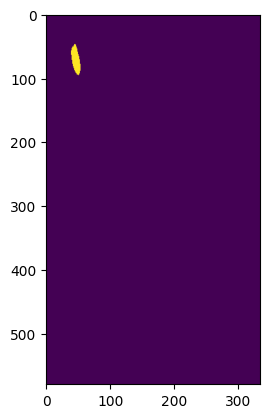

In [24]:
plt.imshow(labeled_regions == 4)


In [25]:
from scipy.ndimage import center_of_mass

# Get unique region labels (excluding background 0)
region_labels = np.unique(labeled_regions)
region_labels = region_labels[region_labels > 0]  # Exclude background (0)

# Compute centroids of each region
centroids = np.array(
    center_of_mass(labeled_regions, labels=labeled_regions, index=region_labels)
)

# Sort by Y first (top to bottom), then by X (left to right)
sorted_indices = np.lexsort((centroids[:, 1], centroids[:, 0]))  # Sort by (Y, X)
new_labels = {old: new + 1 for new, old in enumerate(region_labels[sorted_indices])}

# Create new labeled image
renumbered_regions = np.copy(labeled_regions)
for old_label, new_label in new_labels.items():
    renumbered_regions[labeled_regions == old_label] = new_label

# renumbered_regions = renumbered_regions[renumbered_regions > 0]  # Remove background (0)

In [26]:
np.unique(renumbered_regions)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
      dtype=int32)

In [80]:
import numpy as np
from scipy.ndimage import center_of_mass


def sort_regions_grid(labeled_regions, y_threshold=5):
    region_labels = np.unique(labeled_regions)
    region_labels = region_labels[region_labels > 0]  # Exclude background (0)

    # Compute centroids
    centroids = np.array(
        center_of_mass(labeled_regions, labels=labeled_regions, index=region_labels)
    )

    # Sort centroids by Y-coordinates
    sorted_y_indices = np.argsort(centroids[:, 0])
    centroids = centroids[sorted_y_indices]
    region_labels = region_labels[sorted_y_indices]

    # Cluster regions into rows based on Y proximity
    rows = []
    current_row = [region_labels[0]]

    for i in range(1, len(region_labels)):
        if centroids[i, 0] - centroids[i - 1, 0] > y_threshold:
            rows.append(current_row)
            current_row = []
        current_row.append(region_labels[i])

    rows.append(current_row)  # Append last row

    # Sort each row by X-coordinates
    sorted_labels = []
    for row in rows:
        row_centroids = centroids[np.isin(region_labels, row)]
        sorted_x_indices = np.argsort(row_centroids[:, 1])
        sorted_labels.extend(np.array(row)[sorted_x_indices])

    # Renumber labels
    new_labels = {old: new + 1 for new, old in enumerate(sorted_labels)}
    renumbered_regions = np.copy(labeled_regions)
    for old_label, new_label in new_labels.items():
        renumbered_regions[labeled_regions == old_label] = new_label

    return renumbered_regions


# Usage
renumbered_regions = sort_regions_grid(labeled_regions, y_threshold=25)

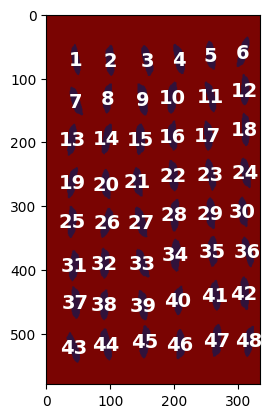

In [28]:
plt.imshow(renumbered_regions == 0, cmap="turbo")
for i in range(1, 49):
    region = renumbered_regions == i
    # compute the center of mass
    center = np.array(center_of_mass(region))
    # print(f"Region {i}: {center}")
    # plt.imshow(renumbered_regions == i)
    # plot centre
    # plt.scatter(center[1], center[0], color="red", s=100, marker="x")
    plt.text(
        center[1],
        center[0],
        str(i),
        color="white",
        fontsize=14,
        fontdict={"weight": "bold"},
        ha="center",
        va="center",
    )
plt.show()

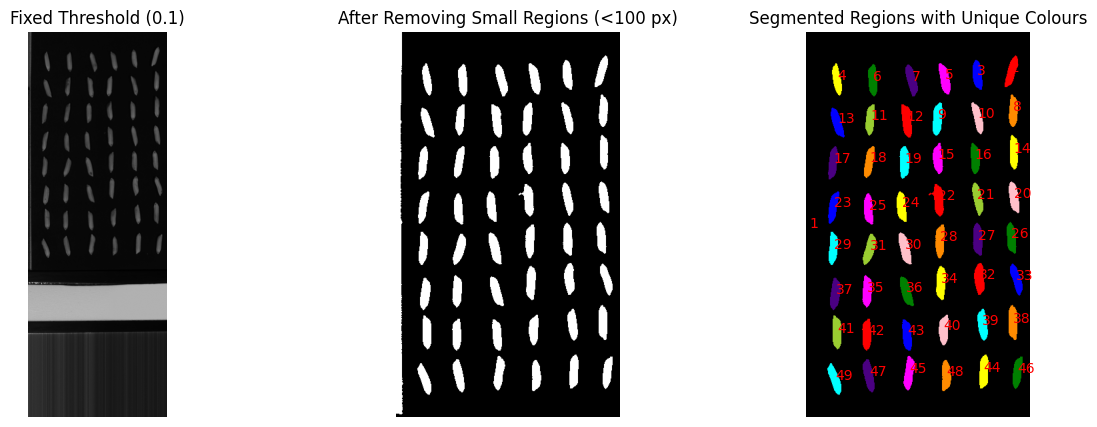

In [29]:
for i in range(10, 11):
    segment_image(i, threshold=0.1, plot=True)

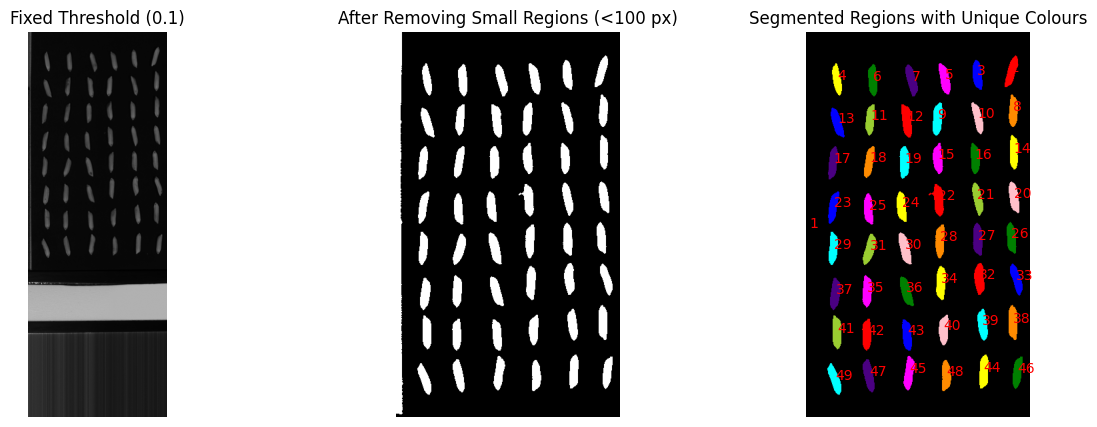

In [30]:
regions = segment_image(i, threshold=0.1, plot=True)

In [31]:
def extract_masks(labeled_regions):
    region_labels = np.unique(labeled_regions)
    region_labels = region_labels[region_labels > 0]  # Exclude background (0)

    masks = {
        label: (labeled_regions == label).astype(np.uint8) for label in region_labels
    }
    return masks  # Dictionary {label: mask}


masks = extract_masks(renumbered_regions)

In [32]:
masks[1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(580, 336), dtype=uint8)

In [33]:
# plt.imshow(df.images[img_num].hsi_calibrated[masks[1]])a


In [34]:
masks[1].shape
# plt.imshow(masks[1], cmap="gray")

(580, 336)

In [35]:
df.images[img_num].hsi_calibrated.shape

(931, 336, 256)

In [36]:
img = df.images[img_num].hsi_calibrated[:580]

In [37]:
img.shape

(580, 336, 256)

In [38]:
masks[1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(580, 336), dtype=uint8)

(60, 60, 256)

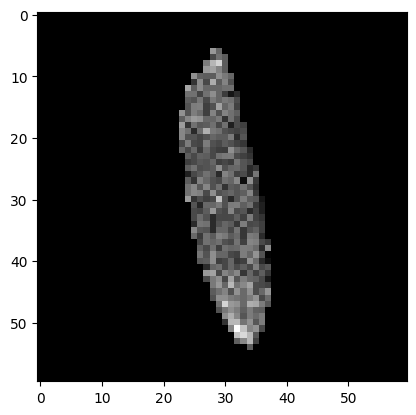

In [103]:
def extract_bounded_seed(specimg, masks, renumbered_regions, region_id, bbox_size = 30):
    res = specimg * masks[region_id][:, :, np.newaxis]
    centroid = center_of_mass(renumbered_regions == region_id)

    # Get a bounding box
    bbox = (np.add(centroid, -bbox_size).astype(int), np.add(centroid, bbox_size).astype(int))
    # print(bbox)
    # print(centroids[1])
    # Crop it
    res = res[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1], :]

    return res


res = extract_bounded_seed(img, masks, renumbered_regions, 1)

plt.imshow(res[:, :, 10], cmap="gray")
res.shape

In [108]:
regions = np.max(renumbered_regions)

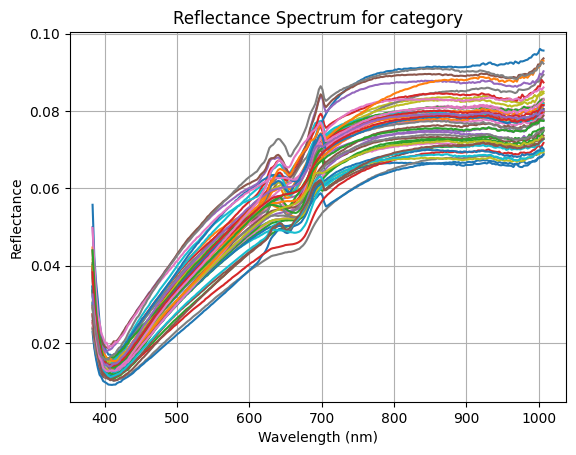

In [ ]:
spectra = [np.mean(res, axis=(0, 1)) for res in [extract_bounded_seed(img, masks, renumbered_regions, i+1) for i in range(regions+1)]]
plt.figure()
for i in range(regions):
    plt.plot(df.images[img_num].wavelengths, spectra[i])
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.title(f"Mean Reflectance Spectrum For {regions} Seeds In Category")
plt.grid(True)
plt.show()

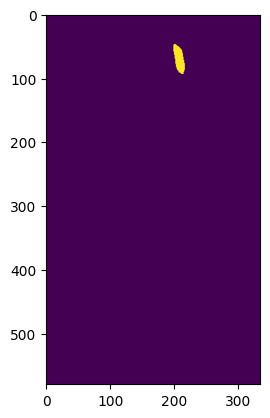

In [43]:
plt.imshow(renumbered_regions == 4)

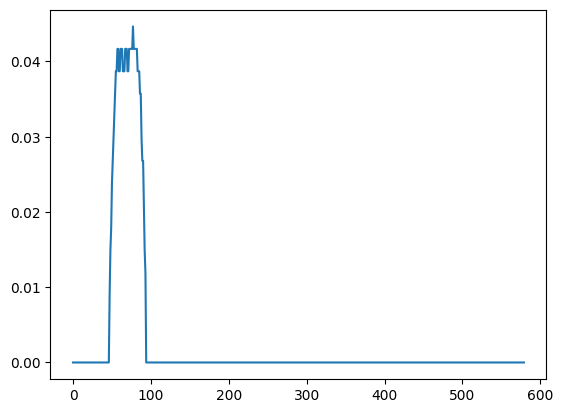

In [50]:
plt.plot(np.mean(renumbered_regions == 4, axis=1))

In [111]:
df

,Species Full Name,Species Short Name,Bundle Number,Folder,File Name
0,BC15,BC15,1,Data-VIS-20170111-1-room-light-off,BC15-01
1,BC15,BC15,2,Data-VIS-20170111-1-room-light-off,BC15-02
2,CT286,CT286,1,Data-VIS-20170111-1-room-light-off,CT286-01
3,CT286,CT286,2,Data-VIS-20170111-1-room-light-off,CT286-02
4,CH12,CH12,1,Data-VIS-20170111-1-room-light-off,CH12-01
...,...,...,...,...,...
175,NT16,NT16,2,Data-VIS-20170117-1-room-light-off,NT16-02
176,TC11-2,TC112,1,Data-VIS-20170117-1-room-light-off,TC11-2-01
177,TC11-2,TC112,2,Data-VIS-20170117-1-room-light-off,TC11-2-02
178,VinhPhuc1,VP1,1,Data-VIS-20170117-1-room-light-off,VinhPhuc1-01
